# Time Series Forcasting with a Linear Regression Model

In [38]:
import pandas as pd
with open("../data/current_measurements.json") as file:
    df = pd.read_json(file)

In [39]:
df = df.iloc[::-1] # reverse the order, the data was ordered by DATE DESC, but we want the more recent data to be used in the test set
df['measuredAt'] = pd.to_datetime(df['measuredAt'])
df.index = df['measuredAt']
del(df['measuredAt'])

In [40]:
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20, 12

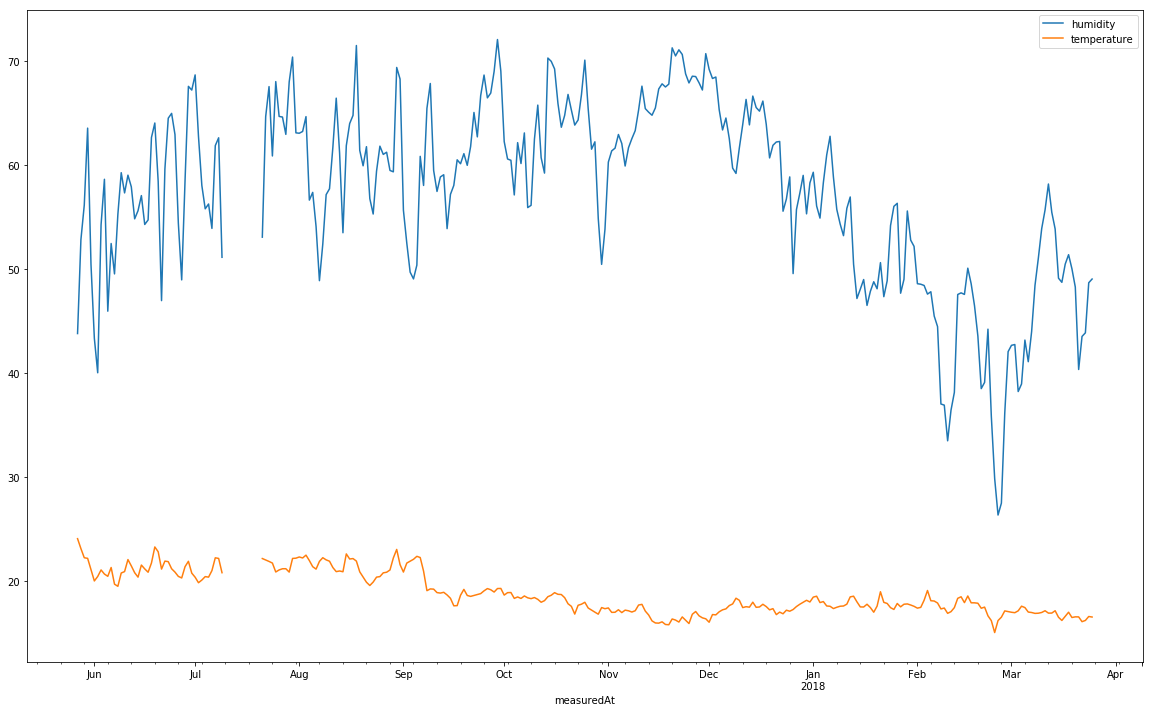

In [41]:
df.resample('D').mean().plot()

In [42]:
df.index

DatetimeIndex(['2017-05-27 16:11:57.235106', '2017-05-27 17:19:42.369249',
               '2017-05-27 17:23:30.756653', '2017-05-27 18:00:17.092384',
               '2017-05-27 18:35:47.109730', '2017-05-27 18:40:53.500771',
               '2017-05-27 19:00:13.771968', '2017-05-27 20:00:10.138441',
               '2017-05-27 21:00:09.525139', '2017-05-27 22:00:40.576659',
               ...
               '2018-03-25 04:00:08.719898', '2018-03-25 05:00:10.807380',
               '2018-03-25 06:00:10.965408', '2018-03-25 07:00:11.341156',
               '2018-03-25 08:00:11.426677', '2018-03-25 09:00:16.555065',
               '2018-03-25 10:00:07.561586', '2018-03-25 11:00:11.698589',
               '2018-03-25 12:00:14.717760', '2018-03-25 13:00:11.230061'],
              dtype='datetime64[ns]', name='measuredAt', length=6917, freq=None)

## building a training and test set

In [43]:
test_size = 0.2
lookback = 24

In [44]:
import numpy as np
dataset = df.humidity.values

In [45]:
X, y = [], []
for i in range(lookback, len(dataset) - lookback):
    X.append(dataset[i-lookback:i])
    y.append(dataset[i:i+lookback])


In [46]:
# split into train and test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, shuffle=False)

## Training the model

In [47]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [48]:
predicted_train = lin_reg.predict(X_train)
predicted_test = lin_reg.predict(X_test)

## Evaluating the results

In [49]:
# %load ../src/visualization/plot_predictions.py
import numpy as np
import matplotlib.pylab as plt


def prepare_plot_data(df, lookback, predicted_train, predicted_test, max_ahead=False):
    if max_ahead:
        offset = lookback * 2
        index = -1
    else:
        offset = lookback
        index = 0

    predicted_train_plot = []
    for i in range(0, predicted_train.shape[0]):
        predicted_train_plot = np.append(
            predicted_train_plot, predicted_train[i, index])

    predicted_test_plot = []
    for i in range(0, predicted_test.shape[0]):
        predicted_test_plot = np.append(
            predicted_test_plot, predicted_test[i, index])

    measured = df[offset:]
    plot_X_train = df.index[offset:len(predicted_train_plot) + offset]
    plot_X_test = df.index[offset + len(predicted_train_plot):offset + len(
        predicted_train_plot) + len(predicted_test_plot)]
    return measured, plot_X_train, predicted_train_plot, plot_X_test, predicted_test_plot


def visualize_predictions(df, lookback, predicted_train, predicted_test, show_measured=True, max_ahead=False, train_color="salmon", test_color="red", label="predicted"):
    measured, plot_X_train, plot_y_train, plot_X_test, plot_y_test = prepare_plot_data(
        df, lookback, predicted_train, predicted_test, max_ahead)
    plt.subplot()
    if show_measured:
        plt.plot(measured.index, measured.humidity, color="gray")
    plt.plot(plot_X_train, plot_y_train,
             color=train_color, label=label + " train")
    plt.plot(plot_X_test, plot_y_test, color=test_color, label=label + " test")
    plt.legend()


Visualization of the 1 hour ahead prediction

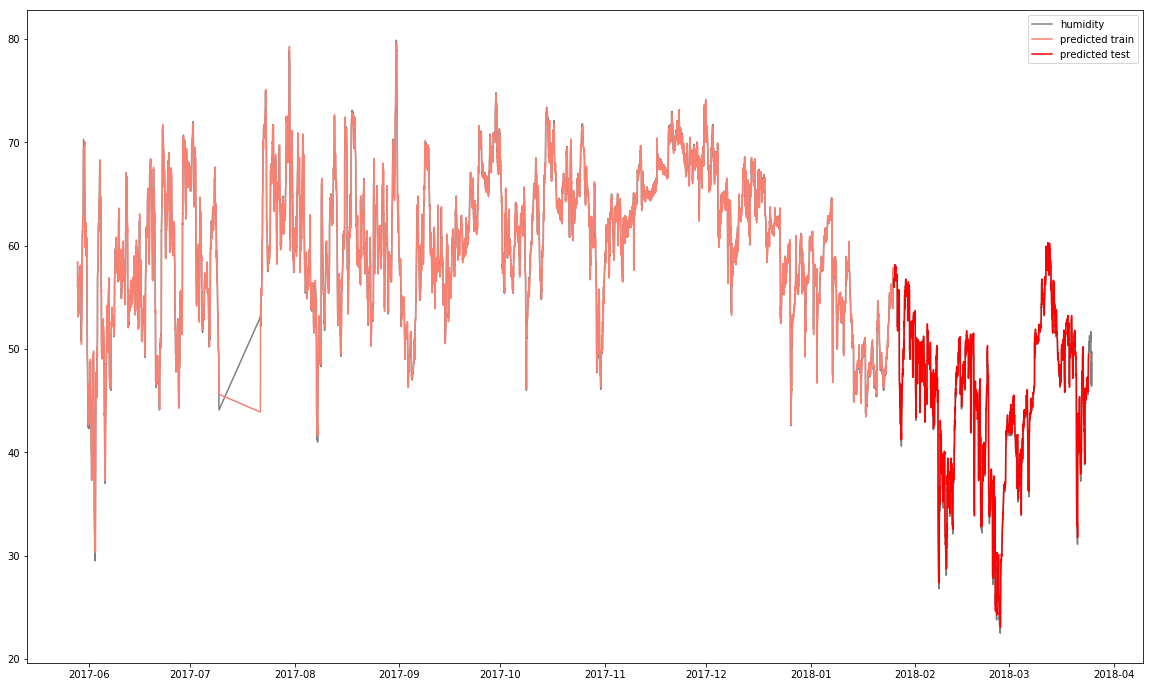

In [50]:
visualize_predictions(df, lookback, predicted_train, predicted_test)

Visualization of the 24 hour ahead prediction

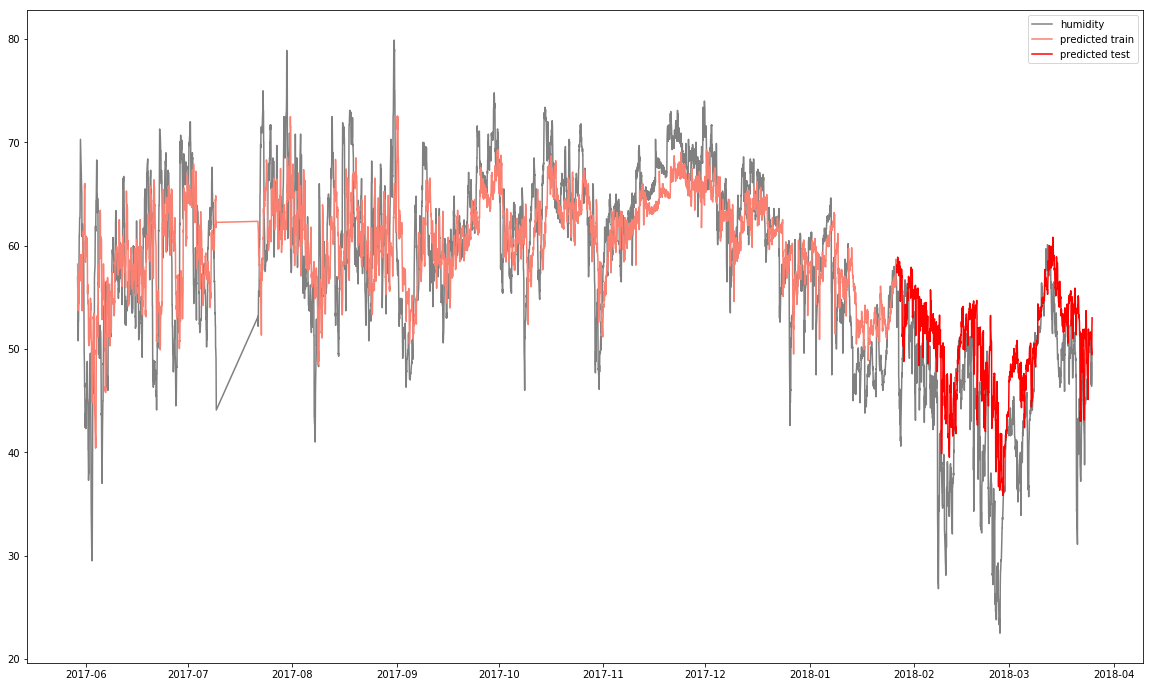

In [51]:
visualize_predictions(df, lookback, predicted_train, predicted_test, max_ahead = True)

Visualizing the differences between predicted and measured humidity values

/Users/oem/.pyenv/versions/3.6.3/envs/habitat/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


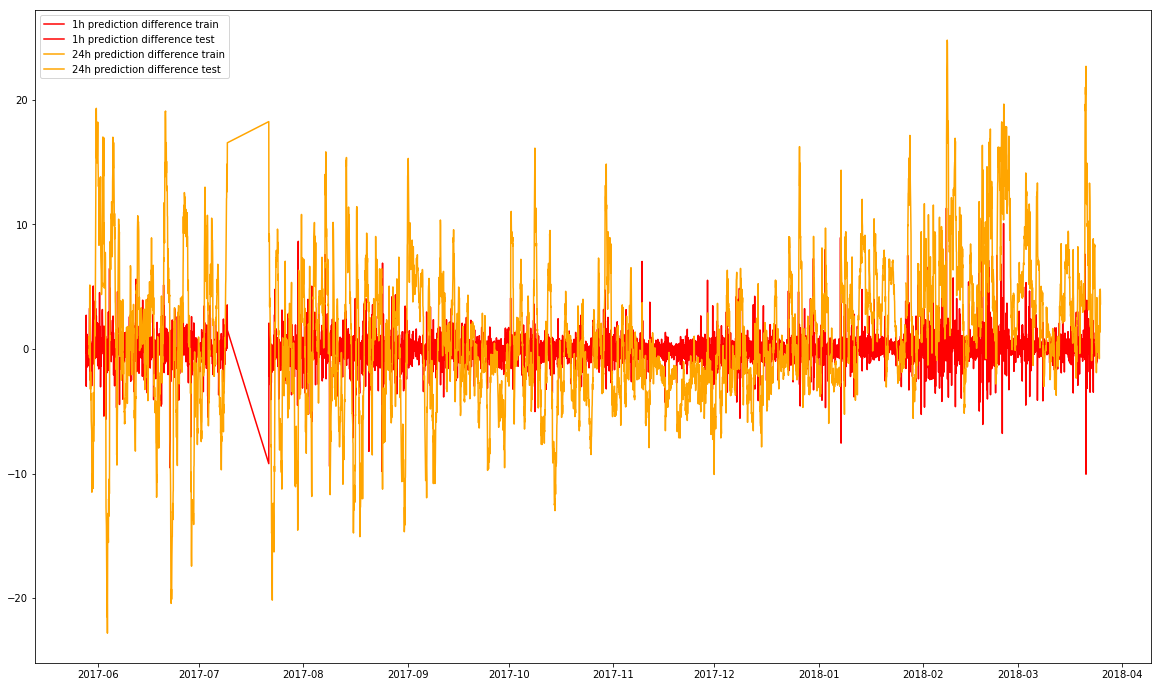

In [52]:
diff_train = np.subtract(predicted_train, y_train)
diff_test = np.subtract(predicted_test, y_test)

visualize_predictions(df, lookback, diff_train, diff_test, show_measured = False, label = "1h prediction difference", train_color = "red")
visualize_predictions(df, lookback, diff_train, diff_test, show_measured = False, max_ahead = True, label = "24h prediction difference", train_color = "orange", test_color = "orange")

In [53]:
# %load ../src/visualization/prediction_histogram.py
import numpy as np
import matplotlib.pylab as plt


def get_1h(t): return t[0]


def get_24h(t): return t[-1]


def plot_histograms(diff_train, diff_test):
    train_1h = np.array([get_1h(x) for x in diff_train])
    train_24h = np.array([get_24h(x) for x in diff_train])
    test_1h = np.array([get_1h(x) for x in diff_test])
    test_24h = np.array([get_24h(x) for x in diff_test])

    plt.hist(train_1h, color="blue",
             label="training set: predicted 1h difference")
    plt.hist(train_24h, color="violet", alpha=0.5,
             label="training set: predicted 24h difference")
    plt.legend()

    plt.figure()
    plt.hist(test_1h, color="orange",
             label="test set: predicted 1h difference")
    plt.hist(test_24h, color="yellow", alpha=0.5,
             label="test set: predicted 24h difference")
    plt.legend()

    plt.show()


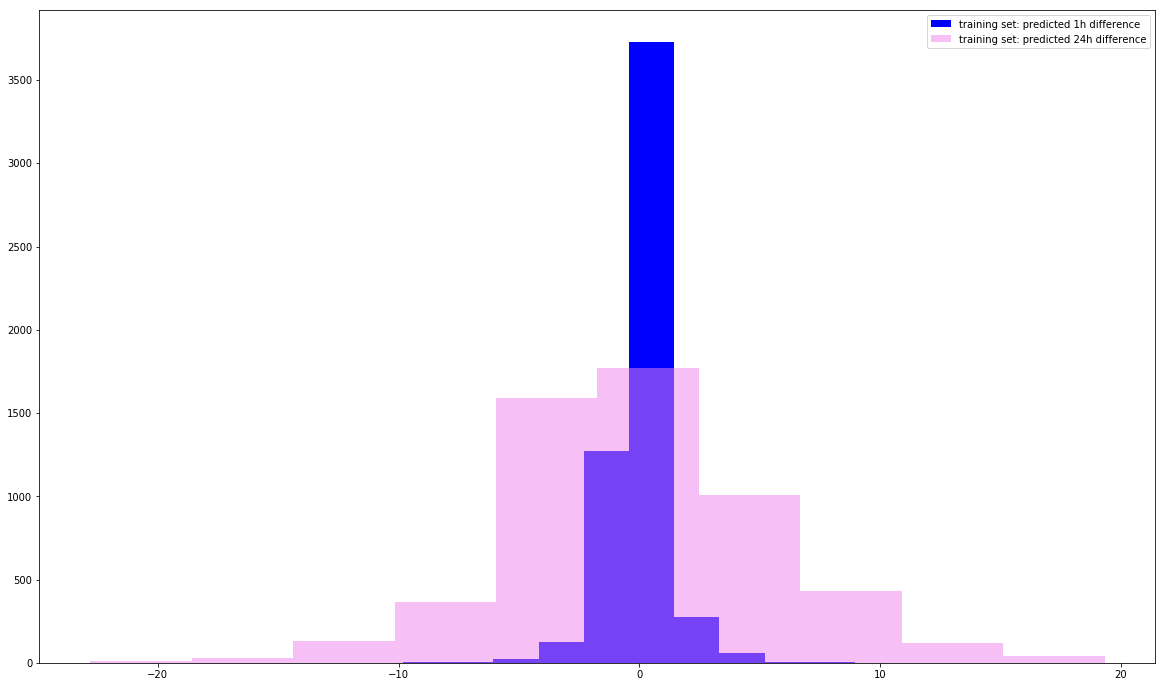

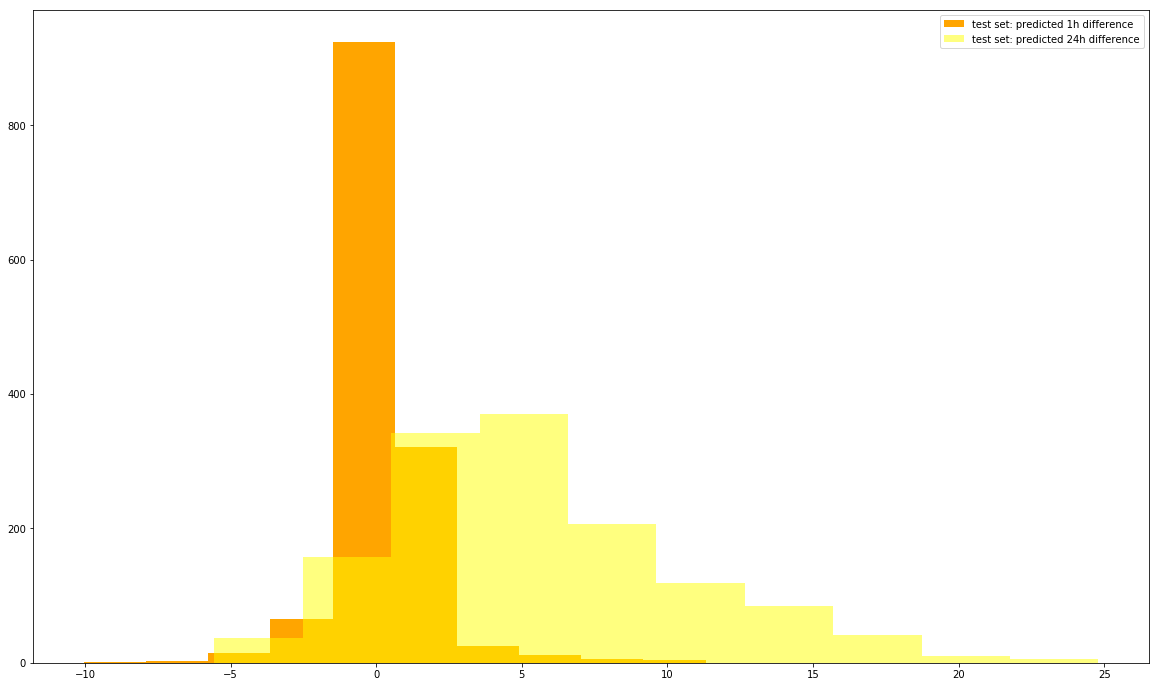

In [54]:
plot_histograms(diff_train, diff_test)

In [55]:
import math
from sklearn.metrics import mean_squared_error, mean_absolute_error

train_rmse = math.sqrt(mean_squared_error(y_train, predicted_train))
test_rmse = math.sqrt(mean_squared_error(y_test, predicted_test))

print("RMSE on training set %.6f" % train_rmse)
print("RMSE on test set %.6f" % test_rmse)


print("MAE on training set %.6f" % mean_absolute_error(y_train, predicted_train))
print("MAE on test set %.6f" % mean_absolute_error(y_test, predicted_test))

RMSE on training set 4.263805
RMSE on test set 5.532864
MAE on training set 3.015405
MAE on test set 3.892465
